In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

In [2]:
SEED = 1

# Import data

In [77]:
raw_data_df = pd.read_csv('loan_data_2007_2014.csv', index_col=0)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [78]:
raw_data_df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,29900.0,NaN,NaN,NaN
466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,D5,...,NaN,NaN,NaN,NaN,NaN,NaN,39400.0,NaN,NaN,NaN
466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,13100.0,NaN,NaN,NaN
466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,53100.0,NaN,NaN,NaN


In [79]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [80]:
raw_data_df.shape

(466285, 74)

# Data cleaning & EDA

## Remove duplicate rows

In [81]:
# Check if there are duplicated rows
raw_data_df['member_id'].duplicated().any()

False

## Drop useless columns

In [82]:
useless_cols = ['id', 
                'member_id', 
                'url',
                'desc',
                'emp_title',
                'pymnt_plan',
                'title',
                'funded_amnt_inv',
                'addr_state',
                'zip_code',
                'pymnt_plan',
                'last_pymnt_d',
                'next_pymnt_d']

clean_df = raw_data_df.drop(columns=useless_cols)

## String manipulation
#### term

In [83]:
list(clean_df['term'].unique())

[' 36 months', ' 60 months']

In [84]:
# In column 'term', remove string 'months'
clean_df['term'] = clean_df['term'].str.replace('months', '')
clean_df['term'] = clean_df['term'].astype(int)

In [85]:
list(clean_df['term'].unique())

[36, 60]

#### emp_length

In [86]:
list(clean_df['emp_length'].unique())

['10+ years',
 '< 1 year',
 '1 year',
 '3 years',
 '8 years',
 '9 years',
 '4 years',
 '5 years',
 '6 years',
 '2 years',
 '7 years',
 nan]

In [87]:
# In column 'emp_length', remove text
clean_df['emp_length'] = clean_df['emp_length'].str.replace('+', '')
clean_df['emp_length'] = clean_df['emp_length'].str.replace(' years', '')
clean_df['emp_length'] = clean_df['emp_length'].str.replace('< 1 year', '0')
clean_df['emp_length'] = clean_df['emp_length'].str.replace(' year', '')

/var/folders/4z/2xj80t2s3bl5rs99dyjfmh780000gn/T/ipykernel_7984/1554144225.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df['emp_length'] = clean_df['emp_length'].str.replace('+', '')


In [88]:
list(clean_df['emp_length'].unique())

['10', '0', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan]

## Check null values

In [89]:
# pd.set_option('display.max_rows', 500)

In [90]:
(clean_df.isnull().sum()/len(clean_df))*100

loan_amnt                        0.000000
funded_amnt                      0.000000
term                             0.000000
int_rate                         0.000000
installment                      0.000000
grade                            0.000000
sub_grade                        0.000000
emp_length                       4.505399
home_ownership                   0.000000
annual_inc                       0.000858
verification_status              0.000000
issue_d                          0.000000
loan_status                      0.000000
purpose                          0.000000
dti                              0.000000
delinq_2yrs                      0.006219
earliest_cr_line                 0.006219
inq_last_6mths                   0.006219
mths_since_last_delinq          53.690554
mths_since_last_record          86.566585
open_acc                         0.006219
pub_rec                          0.006219
revol_bal                        0.000000
revol_util                       0

#### Drop columns with null values above 70%

In [91]:
# Remove columns with null values above 70%

null_cols = ['annual_inc_joint',
            'dti_joint',
            'verification_status_joint',
            'open_acc_6m',
            'open_il_6m',
            'open_il_12m',
            'open_il_24m',
            'mths_since_rcnt_il',
            'mths_since_last_record',
            'mths_since_last_major_derog',
            'total_bal_il',
            'il_util',
            'open_rv_12m',
            'open_rv_24m',
            'max_bal_bc',
            'all_util',
            'inq_fi',
            'total_cu_tl',
            'inq_last_12m']

clean_df = clean_df.drop(columns=null_cols)

#### Impute null values with median

- annual income
- revol_util
- tot_cur_bal
- total_rev_hi_lim

In [93]:
# Impute null values with median

for col in ['annual_inc', 
            'revol_util',
            'tot_cur_bal',
            'total_rev_hi_lim']:
    clean_df[col].fillna(clean_df[col].median(), inplace=True)
    clean_df[col] = clean_df[col].astype(int)

#### Impute null values with mode

- emp_length
- earliest_cr_line
- last_credit_pull_d

In [95]:
# Impute null values with mode

for col in ['emp_length', 
            'earliest_cr_line',
            'last_credit_pull_d']:
    clean_df[col].fillna(clean_df[col].mode()[0], inplace=True)

#### Impute null values as 0

- delinq_2yrs
- inq_last_6mths
- open_acc
- pub_rec
- total_acc
- open_acc
- pub_rec
- collections_12_mths_ex_med
- acc_now_delinq
- tot_coll_amt
- mths_since_last_delinq

In [96]:
# Impute null values as 0
for col in ['delinq_2yrs',
            'inq_last_6mths',
            'open_acc',
            'pub_rec',
            'total_acc',
            'open_acc',
            'pub_rec',
            'collections_12_mths_ex_med',
            'acc_now_delinq',
            'tot_coll_amt',
            'mths_since_last_delinq']:
    clean_df[col].fillna(0, inplace=True)
    clean_df[col] = clean_df[col].astype(int)

#### Final check for null values

In [97]:
# Check null values
clean_df.isnull().any()

loan_amnt                     False
funded_amnt                   False
term                          False
int_rate                      False
installment                   False
grade                         False
sub_grade                     False
emp_length                    False
home_ownership                False
annual_inc                    False
verification_status           False
issue_d                       False
loan_status                   False
purpose                       False
dti                           False
delinq_2yrs                   False
earliest_cr_line              False
inq_last_6mths                False
mths_since_last_delinq        False
open_acc                      False
pub_rec                       False
revol_bal                     False
revol_util                    False
total_acc                     False
initial_list_status           False
out_prncp                     False
out_prncp_inv                 False
total_pymnt                 

## Set target variable

The target variable is determined from the loan status in the dataset.

Low risk (0) includes:
- 'Does not meet the credit policy. Status:Fully Paid',
- 'Fully Paid', 
- 'Current'


High risk (1) includes:
- 'Does not meet the credit policy. Status:Charged Off'
- 'Charged Off'
- 'Default'
- 'Late (31-120 days)'
- 'In Grace Period'
- 'Late (16-30 days)

In [98]:
# Loan status categories
list(clean_df['loan_status'].unique())

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off']

In [99]:
# high_risk = ['Does not meet the credit policy. Status:Charged Off',
#              'Charged Off',
#              'Default',
#              'Late (31-120 days)',
#              'In Grace Period',
#              'Late (16-30 days)']
low_risk = ['Does not meet the credit policy. Status:Fully Paid',
            'Fully Paid', 
            'Current']

In [100]:
# Change loan status to its corresponding labels
clean_df['loan_status'] = clean_df['loan_status'].apply(lambda s: 0 if s in low_risk else 1)

In [101]:
list(clean_df['loan_status'].unique())

[0, 1]

## Check data correlation
Data correlation is important in weeding out unnecessary features that would create a faster and better working prediction model.

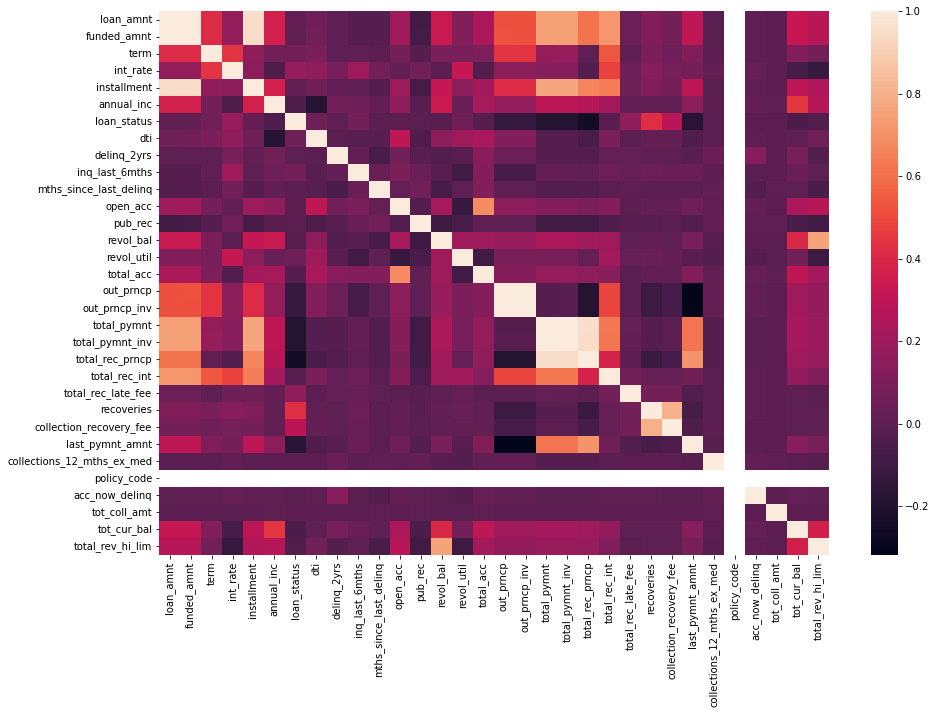

In [102]:
# Create correlation matrix
corr_matrix = clean_df.corr()

# Display correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix)
plt.show()

### Remove low correlating data

In [109]:
# Remove low correlating data
clean_df = clean_df.drop(columns=['policy_code','recoveries','collection_recovery_fee'])

# Feature engineering

In [138]:
# Separate features with target variable
y = clean_df['loan_status']
X = clean_df.drop(columns=['loan_status'])

## Encode categorical data

In [139]:
# Get columns with categorical data
categorical_cols = list(X.select_dtypes(include=['object']).columns)
categorical_cols

['grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'purpose',
 'earliest_cr_line',
 'initial_list_status',
 'last_credit_pull_d',
 'application_type']

In [140]:
# Encode categorical data
X = pd.get_dummies(X, columns=categorical_cols)

## Data normalization

In [141]:
# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Label encoding

In [143]:
# Encode target variable
lab_encoder = LabelEncoder()
y = lab_encoder.fit_transform(y)

## Split train and test data

In [144]:
# Split data to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [145]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('\nX_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (373028, 965)
y_train: (373028,)

X_test: (93257, 965)
y_test: (93257,)


# Build model

## Random Forest

In [148]:
# Build model
rfc_model = RandomForestClassifier(random_state=SEED, n_jobs=-1, verbose=1)

In [149]:
# Train model
rfc_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomForestClassifier(n_jobs=-1, random_state=1, verbose=1)

# Model evaluation
The model is evaluated using four evaluation metrics:
1. Accuracy
2. Precision
3. Recall
4. ROC-AUC score

As the dataset is imbalanced, the different evaluation metrics would be more helpful in determining the performance of the model, rather than just using accuracy as the evaluation metric.

In [147]:
def print_metrics(y_test, y_preds):
    metrics = {'accuracy': accuracy_score(y_test, y_preds),
               'precision':  precision_score(y_test, y_preds, average='macro'),
               'recall': recall_score(y_test, y_preds, average='macro'),
               'roc_auc': roc_auc_score(y_test, y_preds, average='macro')}

    print("Results on testing set")
    print("----------------------")
    print("Accuracy score:", metrics['accuracy'])
    print("Precision score:", metrics['precision'])
    print("Recall score:", metrics['recall'])
    print("ROC-AUC score:", metrics['roc_auc'])

In [150]:
print_metrics(y_test, rfc_model.predict(X_test))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s


Results on testing set
----------------------
Accuracy score: 0.9671123883461832
Precision score: 0.9816528055978228
Recall score: 0.8630672056648756
ROC-AUC score: 0.8630672056648756


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished
